# Close approaches predictions
Written by Jackey Fang<br>
<br>
**Last Update**<br>
2026-03-01

# Info
### NASA SBDB: 
- Reference frame: J2000 ecliptic
- Heliocentric orbit
- Elements: deg
- Cov: deg
- Time: MJD
<br>

### ESA NEOCC:
- Reference frame: J2000 ecliptic
- Heliocentric orbit
- Elements: equinoctial, deg
- Cov: equinoctial, deg
- Time: MJD
<br>

### Horizon:
- J2000 ecliptic
- JD
- Barycentric

# Imports

In [29]:
import requests
import numpy as np
import rebound
import warnings
import matplotlib.pyplot as plt
import os
import contextlib
import pyarrow.parquet as pq
from astropy.time import Time
from erfa.core import ErfaWarning

# API and Data Extraction

In [30]:
def fetch_data(asteroid_id):
    """
    Get orbital elements and covariance matrix of asteroid from each agencies
    """
    print(f"Fetching Data for {asteroid_id}")

    # NASA SBDB API
    nasa_url = f"https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={asteroid_id}&cov=mat&full-prec=true"
    print("Fetching from NASA SBDB...")
    nasa_req = requests.get(nasa_url)
   
    if nasa_req.status_code == 200:
        nasa_data = nasa_req.json()
       
        # Grab the labels
        raw_labels = nasa_data['orbit']['covariance']['labels'][:6]
        name_map = {'node': 'om', 'peri': 'w'}
        nasa_labels = [name_map.get(lbl, lbl) for lbl in raw_labels]

        # Covariance Matrix
        nasa_covariance = np.array(nasa_data['orbit']['covariance']['data'], dtype=float)
        nasa_covariance_6 = nasa_covariance[:6, :6]
        
        nasa_scale = np.ones(6)
        angle_labels = ['om', 'w', 'i', 'ma']
        
        for idx, label in enumerate(nasa_labels):
            if label in angle_labels:
                nasa_scale[idx] = np.pi / 180.0
                
        # Apply the scaling
        nasa_covariance_6 = nasa_covariance_6 * np.outer(nasa_scale, nasa_scale)
        
        # Build dict
        if 'elements' in nasa_data['orbit']['covariance']:
            elements_list = nasa_data['orbit']['covariance']['elements']
            nasa_epoch_jd = float(nasa_data['orbit']['covariance']['epoch'])
        else:
            elements_list = nasa_data['orbit']['elements']
            nasa_epoch_jd = float(nasa_data['orbit']['epoch'])

        elements_dict = {item['name']: float(item['value']) for item in elements_list}

        # Key map
        nasa_elements = []

        for label in nasa_labels:
            val = elements_dict[label]

            # Convert mean elements to radians to match the covariance matrix!
            if label in angle_labels:
                val = np.radians(val)
                
            nasa_elements.append(val)

        nasa_elements = np.array(nasa_elements, dtype=float)
        print(f"NASA Data Retrieved in format: {nasa_labels}")

    else:
        print("NASA fetch failed.")
        return None, None, None, None, None, None, None, None

    # ESA NEO API
    esa_id = asteroid_id.replace(" ", "")
    esa_url = f"https://neo.ssa.esa.int/PSDB-portlet/download?file={esa_id}.eq0"
    print("\nFetching from ESA NEO Portal...")
    esa_req = requests.get(esa_url)

    if esa_req.status_code == 200 and "END_OF_HEADER" in esa_req.text:
        esa_covariance = []
        esa_elements = []
        esa_labels = ['a', 'h', 'k', 'p', 'q', 'lon']

        for line in esa_req.text.splitlines():
            clean_line = line.strip()
            if clean_line.startswith('MJD'):
                mjd = float(clean_line.split()[1])
                esa_epoch_jd = mjd + 2400000.5
                
            elif clean_line.startswith('EQU'):
                esa_elements = np.array([float(x) for x in clean_line.split()[1:7]])
                
            elif clean_line.startswith('COV'):
                esa_covariance.extend([float(x) for x in clean_line.split()[1:]])

        # Reconstruct the matrix
        N_items = len(esa_covariance)
        n_dim = int((np.sqrt(1 + 8 * N_items) - 1) / 2)

        esa_covariance_full = np.zeros((n_dim, n_dim))
        idx = 0
        for i in range(n_dim):
            for j in range(i, n_dim):
                esa_covariance_full[i, j] = esa_covariance[idx]
                esa_covariance_full[j, i] = esa_covariance[idx] 
                idx += 1

        esa_covariance_6 = esa_covariance_full[:6, :6]
                
        esa_scale = np.ones(6)
        angle_labels = ['lon']
        
        for index, label in enumerate(esa_labels):
            if label in angle_labels:
                esa_scale[index] = np.pi / 180.0
                esa_elements[index] = np.radians(esa_elements[index])
                
        esa_covariance_6 = esa_covariance_6 * np.outer(esa_scale, esa_scale)
               
        print(f"ESA Data Retrieved in format: {esa_labels}")

    else:
        print("ESA fetch failed.")
        return nasa_elements, nasa_covariance_6, nasa_labels, nasa_epoch_jd, None, None, None, None

    return nasa_elements, nasa_covariance_6, nasa_labels, nasa_epoch_jd, esa_elements, esa_covariance_6, esa_labels, esa_epoch_jd

# Virtual Asteroids

In [31]:
def generate_virtual_asteroids(orb_elements, covariance_matrix, num_samples=1000, rng=None):
    """
    Sample virtual asteroids from mean `orb_elements` and covariance `covariance_matrix`.
    Ensures cov is symmetric and positive semidefinite by adding the minimal diagonal jitter.
    """
    orb_elements = np.asarray(orb_elements, dtype=float)
    cov = np.asarray(covariance_matrix, dtype=float)

    # Basic shape checks
    if cov.ndim != 2 or cov.shape[0] != cov.shape[1]:
        raise ValueError("covariance_matrix must be square")
    if orb_elements.ndim != 1 or orb_elements.shape[0] != cov.shape[0]:
        raise ValueError("orb_elements length must match covariance dimensions")

    # Symmetrize
    cov = 0.5 * (cov + cov.T)

    # Eigen check
    eigvals = np.linalg.eigvalsh(cov)
    min_eig = eigvals[0]

    # Scale
    scale = max(np.max(np.abs(eigvals)), 1.0)
    tol = scale * 1e-15   # machine-eps-style tolerance relative to scale

    if min_eig < tol:
        # add just enough to make the minimum eigenvalue ~ tol
        add = (tol - min_eig)
        cov += np.eye(cov.shape[0]) * add

    # Regularization
    cov += np.eye(cov.shape[0]) * (1e-16 * max(scale, 1.0))

    if rng is None:
        rng = np.random.default_rng()

    vas = rng.multivariate_normal(mean=orb_elements, cov=cov, size=num_samples)
    vas[0] = orb_elements
    return vas

# Convert to cartesian coordinates

In [32]:
def translate_to_cartesian(vas_matrix, labels, native_epoch_jd):
    """
    Translates orbital elements to Barycentric coordinates 
    at their epoch
    """
    print(f"Translating {len(vas_matrix)} asteroids at JD {native_epoch_jd}...")
    cartesian_matrix = np.zeros((len(vas_matrix), 6))
    
    sim = rebound.Simulation()
    sim.units = ('AU', 'days', 'Msun')
    
    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        sim.add("Sun", date=f"JD {native_epoch_jd}")
    
    k_gauss = 0.01720209895

    for i in range(len(vas_matrix)):
        row = vas_matrix[i]
        data = {labels[j]: row[j] for j in range(6)}
        
        try:
            # NASA cometary translation
            if 'q' in labels and 'tp' in labels:
                e = data['e']
                q = data['q']
                
                a = q / (1.0 - e) if e < 1.0 else q 
                inc = data['i']
                Omega = data['om'] 
                omega = data['w']
                
                n = k_gauss / (a**1.5)
                m_native = n * (native_epoch_jd - data['tp'])
                m_native = m_native % (2 * np.pi)

            # ESA equinoctial translation
            elif 'h' in labels and 'k' in labels:
                a, h, k = data['a'], data['h'], data['k']
                p, q_eq = data['p'], data['q'] 
                lon = data['lon']
                
                e = np.sqrt(h**2 + k**2)
                inc = 2 * np.arctan(np.sqrt(p**2 + q_eq**2))
                Omega = np.arctan2(p, q_eq) if (p!=0 or q_eq!=0) else 0.0
                omega = np.arctan2(h, k) - Omega if (h!=0 or k!=0) else 0.0

                m_native = lon - omega - Omega
                m_native = m_native % (2 * np.pi)

            # ESA standard keplerian
            else:
                a = data['a']
                e = data['e']
                inc = data['i']
                Omega = data['om']
                omega = data['w']
                m_native = data['ma']

            # Add the Virtual Asteroid to the REBOUND simulation at epoch
            sim.add(a=a, e=e, inc=inc, Omega=Omega, omega=omega, M=m_native, primary=sim.particles[0])
            p_cart = sim.particles[-1]

            cartesian_matrix[i] = [p_cart.x, p_cart.y, p_cart.z, p_cart.vx, p_cart.vy, p_cart.vz]
            sim.remove(index=len(sim.particles)-1)
            
        except Exception as e:
            pass
            
    print("Translation complete.")
    return cartesian_matrix

# N body sim

In [33]:
def nbody_simulation(cartesian_matrix, start_jd, impact_date_utc):
    """
    Flies a cloud of asteroids forward in time and maps them onto the Earth's Target Plane.
    """
    # Convert the Impact Date to a Julian Date
    date_str, frac_str = impact_date_utc.split('.')
    t_midnight = Time(f"{date_str}T00:00:00", format='isot', scale='tdb')
    impact_jd = t_midnight.jd + float(f"0.{frac_str}")
    
    # Set up the Solar System
    sim = rebound.Simulation()
    sim.units = ('AU', 'days', 'Msun')
    sim.t = start_jd
    
    # Add the gravitational heavyweights
    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
        sim.add("Sun", date=f"JD{start_jd}")
        sim.add("199", date=f"JD{start_jd}") # Mercury
        sim.add("299", date=f"JD{start_jd}") # Venus
        sim.add("399", date=f"JD{start_jd}") # Earth
        sim.add("301", date=f"JD{start_jd}") # Moon
        sim.add("499", date=f"JD{start_jd}") # Mars
        sim.add("5", date=f"JD{start_jd}")   # Jupiter Barycenter
        sim.add("6", date=f"JD{start_jd}")   # Saturn Barycenter
        sim.add("7", date=f"JD{start_jd}")   # Uranus Barycenter
        sim.add("8", date=f"JD{start_jd}")   # Neptune Barycenter
    
    earth_idx = 3
    nominal_ast_idx = 10

    # Load nominal asteroid
    nominal_cart = cartesian_matrix[0]
    sim.add(x=nominal_cart[0], y=nominal_cart[1], z=nominal_cart[2], 
            vx=nominal_cart[3], vy=nominal_cart[4], vz=nominal_cart[5], 
            m=0.0)
    
    # Load the Virtual Asteroids as massless
    for cart in cartesian_matrix[1:]:
        sim.add(x=cart[0], y=cart[1], z=cart[2], 
                vx=cart[3], vy=cart[4], vz=cart[5], 
                m=0.0)
    
    # Fast forward
    sim.move_to_com()
    sim.integrate(impact_jd)

    # Calculate the Target Plane
    earth = sim.particles[earth_idx]
    nom_ast = sim.particles[nominal_ast_idx]
    
    # Define the angle of the incoming cloud
    v_rel = np.array([nom_ast.vx - earth.vx, nom_ast.vy - earth.vy, nom_ast.vz - earth.vz])
    v_norm = v_rel / np.linalg.norm(v_rel) # The Eta axis (direction of travel)
    
    # Define the 2D cross-section axes
    k_hat = np.array([0, 0, 1])
    xi_dir = np.cross(v_norm, k_hat)
    xi_dir = xi_dir / np.linalg.norm(xi_dir)
    zeta_dir = np.cross(xi_dir, v_norm)
    
    # Map all asteroids onto the 2D plane
    b_plane_coords = np.zeros((len(cartesian_matrix), 2))
    AU_TO_EARTH_RADII = 23454.8 # Conversion factor

    # Map the nominal asteroid
    r_rel_nom = np.array([nom_ast.x - earth.x, nom_ast.y - earth.y, nom_ast.z - earth.z])
    xi_nom = np.dot(r_rel_nom, xi_dir) * AU_TO_EARTH_RADII
    zeta_nom = np.dot(r_rel_nom, zeta_dir) * AU_TO_EARTH_RADII
    b_plane_coords[0] = [xi_nom, zeta_nom]
    
    for i in range(1, len(cartesian_matrix)):
        ast = sim.particles[i + nominal_ast_idx] 
        r_rel = np.array([ast.x - earth.x, ast.y - earth.y, ast.z - earth.z])
        
        xi = np.dot(r_rel, xi_dir) * AU_TO_EARTH_RADII
        zeta = np.dot(r_rel, zeta_dir) * AU_TO_EARTH_RADII
        b_plane_coords[i] = [xi, zeta]

    warnings.simplefilter('ignore', category=ErfaWarning)

    return b_plane_coords

# Plot

In [34]:
def plot_target_plane(nasa_bplane, esa_bplane):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Plot NASA Cloud (Blue)
    plt.scatter(nasa_bplane[:, 0], nasa_bplane[:, 1], 
                s=10, alpha=0.5, color='royalblue', label='NASA')

    # Plot ESA Cloud (Orange)
    plt.scatter(esa_bplane[:, 0], esa_bplane[:, 1], 
                s=10, alpha=0.5, color='darkorange', label='ESA')
    
    # Medians calc
    nasa_median_xi = np.nanmedian(nasa_bplane[:, 0])
    
    esa_median_xi = np.nanmedian(esa_bplane[:, 0])

    # NASA Median
    plt.axvline(nasa_median_xi, color='blue', linestyle=':', linewidth=1.5, label='NASA Median')
    
    # ESA Median
    plt.axvline(esa_median_xi, color='red', linestyle=':', linewidth=1.5, label='ESA Median')
    
    # Draw the Earth to scale at (0,0)
    earth = plt.Circle((0, 0), 1.0, color='mediumseagreen', alpha=0.8, label='Earth')
    ax.add_patch(earth)

    # Find the maximum distance in any direction across both clouds
    all_data = np.vstack((nasa_bplane, esa_bplane))
    max_limit = np.max(np.abs(all_data)) * 1.1 # Add 10% visual padding
    
    max_limit = max(max_limit, 5.0) 
    #max_limit = 15000

    ax.set_xlim(-max_limit, max_limit)
    ax.set_ylim(-max_limit, max_limit)

    # Formatting
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    
    plt.xlabel(r'$\xi$ (Earth Radii)')
    plt.ylabel(r'$\zeta$ (Earth Radii)')
    plt.title('Target Plane of Close Approaches - 2010 RF12')
    
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right')
    
    ax.set_aspect('equal', adjustable='box') 

    plt.tight_layout()
    plt.show()

# Plot Zoom in

In [35]:
def plot_target_plane_limit(nasa_bplane, esa_bplane, x_max, x_min, y_max, y_min):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Plot NASA cloud
    plt.scatter(nasa_bplane[:, 0], nasa_bplane[:, 1], 
                s=10, alpha=0.5, color='royalblue', label='NASA')

    # Plot ESA cloud
    plt.scatter(esa_bplane[:, 0], esa_bplane[:, 1], 
                s=10, alpha=0.5, color='darkorange', label='ESA')
    
    # Medians calc
    nasa_median_xi = np.nanmedian(nasa_bplane[:, 0])
    
    esa_median_xi = np.nanmedian(esa_bplane[:, 0])

    # NASA Median
    plt.axvline(nasa_median_xi, color='blue', linestyle=':', linewidth=1.5, label='NASA Median')
    
    # ESA Median
    plt.axvline(esa_median_xi, color='red', linestyle=':', linewidth=1.5, label='ESA Median')

    # Draw the Earth to scale at (0,0)
    earth = plt.Circle((0, 0), 1.0, color='mediumseagreen', alpha=0.8, label='Earth')
    ax.add_patch(earth)

    # Set limits
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Formatting
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    
    plt.xlabel(r'$\xi$ (Earth Radii)')
    plt.ylabel(r'$\zeta$ (Earth Radii)')
    plt.title('Target Plane of Close Approaches - 2010 RF12')
    
    plt.grid(True, alpha=0.3, linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=9)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_aspect('equal', adjustable='box') 

    plt.tight_layout()
    plt.show()

# Impact Probabilities

In [36]:
def compute_impact_probability(bplane_data, num_asteroids):
    # distance from origin
    radial_distances = np.sqrt(bplane_data[:, 0]**2 + bplane_data[:, 1]**2)
    
    # Count how many dots fall within 1 R_earth
    impact_count = np.sum(radial_distances <= 1.0)
    
    # Compute the probability
    impact_probability = (impact_count / num_asteroids) * 100
    
    return impact_count, impact_probability

# Execution

In [37]:
asteroid = "2025 HG"
nasa_ele, nasa_cov, nasa_lbl, nasa_epoch, esa_ele, esa_cov, esa_lbl, esa_epoch = fetch_data(asteroid)

Fetching Data for 2025 HG
Fetching from NASA SBDB...
NASA Data Retrieved in format: ['e', 'q', 'tp', 'om', 'w', 'i']

Fetching from ESA NEO Portal...
ESA Data Retrieved in format: ['a', 'h', 'k', 'p', 'q', 'lon']


In [38]:
num_asteroids = 100

# Spawn NASA
nasa_vas = generate_virtual_asteroids(nasa_ele, nasa_cov, num_asteroids)

# Spawn ESA
esa_vas = generate_virtual_asteroids(esa_ele, esa_cov, num_asteroids)

In [39]:
nasa_cartesian = translate_to_cartesian(nasa_vas, nasa_lbl, nasa_epoch)
esa_cartesian = translate_to_cartesian(esa_vas, esa_lbl, esa_epoch)

Translating 100 asteroids at JD 2460783.5...
Translation complete.
Translating 100 asteroids at JD 2460784.26501719...
Translation complete.


In [40]:
impact_date = "2074-04-19.58"

# NASA 
nasa_target_plane = nbody_simulation(nasa_cartesian, nasa_epoch, impact_date)

# ESA 
esa_target_plane = nbody_simulation(esa_cartesian, esa_epoch, impact_date)

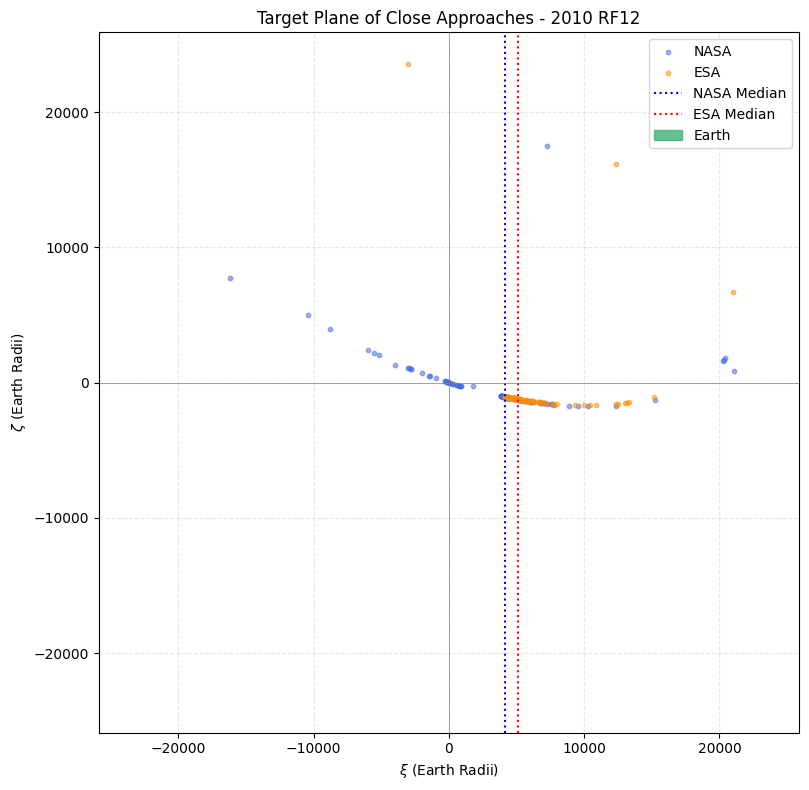

In [41]:
plot_target_plane(nasa_target_plane, esa_target_plane)

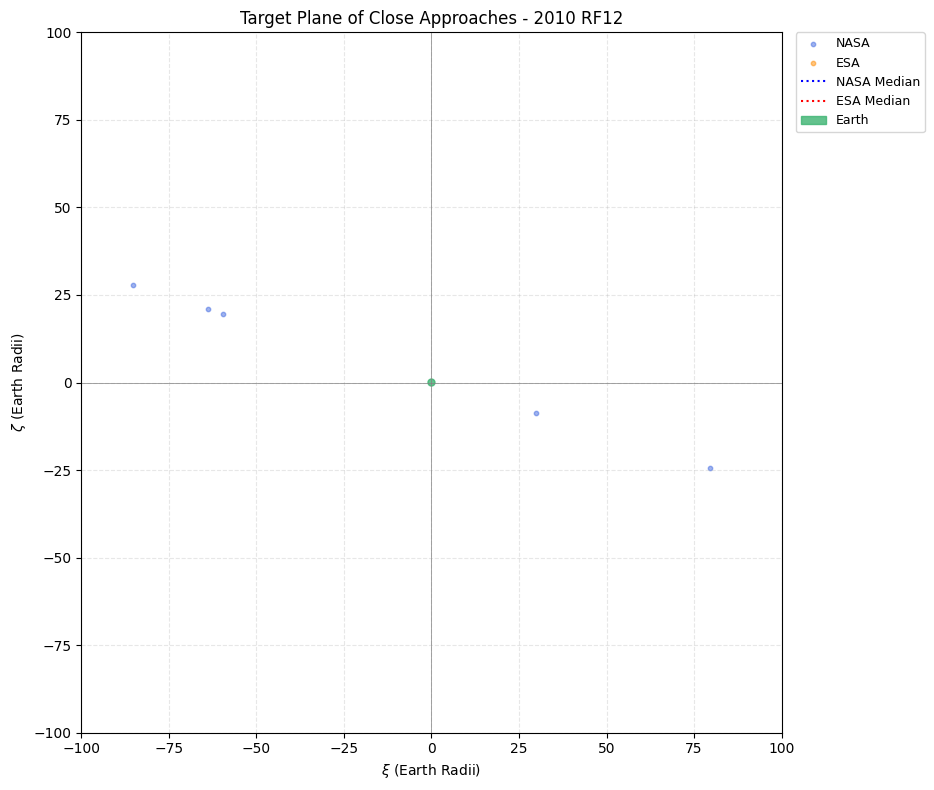

In [43]:
plot_target_plane_limit(nasa_target_plane, esa_target_plane, 100, -100, 100, -100)